In [1]:
import msgpack
import open3d as o3d
import trimesh
import point_cloud_utils as pcu # downsampling
from IPython.display import display, Math
import numpy as np
import matplotlib.pyplot as plt
import numba
from joblib import Parallel, delayed # multiprocessing
import multiprocessing
import copy
from scipy.ndimage.morphology import binary_dilation, binary_erosion
from scipy.spatial.transform import Rotation

plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'

print(f"open3d :{o3d.__version__}")
print(f"trimesh:{trimesh.__version__}")
print(f"numba  :{numba.__version__}")
###########################################################
def NormalizeSignedDistance(signed_distance, zero_map_to=0.5):
    """
    Normalize to 0-1
    min-0 map to 0-0.5
    0-max map to 0.5-1
    """
    is_negative = signed_distance < 0

    normalized_distance = np.zeros_like(signed_distance)
    minimum = signed_distance.min()
    maximum = signed_distance.max()
    normalized_distance[is_negative] = (
        signed_distance[is_negative] - minimum) / np.abs(minimum) * zero_map_to
    normalized_distance[~is_negative] = zero_map_to + \
        signed_distance[~is_negative]/np.abs(maximum)*(1-zero_map_to)
    return normalized_distance


# https://matplotlib.org/tutorials/colors/colormaps.html
cmap = plt.cm.get_cmap('hot')

coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=60, origin=[0, 0, 0])


def rotate_view(vis):
    ctr = vis.get_view_control()
    ctr.rotate(1.0, 0.0)
    return False

# @numba.jit(["float64[:,:](float64[:,::1], float64,int64)",
#             "float64[:,:](float64[:,:], float64,int64)"],nopython=True)



@numba.jit([
    (numba.types.Array(numba.types.float64, 2, 'C', readonly=True),numba.types.float64,numba.types.int64),
    (numba.types.Array(numba.types.float64, 2, 'C', readonly=False),numba.types.float64,numba.types.int64)],
    nopython=True,nogil=True)
def UniformRandomAroundPoints(points,radius,num_per_grid=50):
    num_grid = points.shape[0]
    xyz = np.empty((num_grid*num_per_grid,3),dtype=np.float64)
#     for i,point in enumerate(points):
    for i in range(num_grid):
        point = points[i]
        start = num_per_grid*i
        end = start+num_per_grid
        xyz[start:end,0] = np.random.uniform(point[0]-radius,point[0]+radius,num_per_grid)
        xyz[start:end,1] = np.random.uniform(point[1]-radius,point[1]+radius,num_per_grid)
        xyz[start:end,2] = np.random.uniform(point[2]-radius,point[2]+radius,num_per_grid)
    return xyz

# example, compile
_ = UniformRandomAroundPoints(np.zeros((2,3)),1.0,num_per_grid=5) 
_ = UniformRandomAroundPoints(np.ascontiguousarray(np.zeros((2,3))),1.0,num_per_grid=5) 
########################################################################################
########## geometry #####################################################################
def RotateFromVec(vec, angle):
    vec = np.asarray(vec, dtype=np.float64)
    vec_norm = np.linalg.norm(vec)
    if vec_norm != 1:
        vec = vec/vec_norm
    vec *= angle
    h = np.eye(4)
    h[:3, :3] = Rotation.from_rotvec(vec).as_matrix()
    return h


def Translate(vec, h=None):
    if h is None:
        h = np.eye(4)
    h[:3, -1] += vec
    return h

def ApplyTransform(xyz, t):
    """
    apply transform t to xyz, !!Note that t is transposed!!!
    if transform.shape=(3,3): rotation
    if transform.shape=(4,4): homogegenious transformation (rotation+translation)
    """
    xyz = np.asarray(xyz)
    if t.shape == (3,3): # rotation matrix
        return np.dot(xyz, t.T)
    elif t.shape ==(4,4): # homogeneous matrix
        return np.dot(xyz, t[:-1, :-1].T)+t[:-1, -1]
    else:
        raise AssertionError("dimension error")

open3d :0.11.1
trimesh:3.8.12
numba  :0.51.2


In [155]:
########## discretization parameters ##############
radius_poisson = float(10) # radius for the poisson sampling
radius_knn = radius_poisson*np.sqrt(3)*1.4
# max_nn = 28 # maximun number of neighbors for a mass point (including self)
max_nn = int(24)
inv_scale_grid = float(2.5/np.sqrt(3))
# inv_scale_grid = 1
radius_grid = radius_poisson/np.sqrt(3)/inv_scale_grid # radius for voxelizing before poisson sampling
# radius_grid = radius_poisson/2.5

num_per_grid = int(32/(inv_scale_grid**3))
print(radius_knn)
print(num_per_grid)
print(radius_grid)

24.248711305964278
10
4.0


In [326]:
from numba import int32, float64,boolean    # import the types
from numba.experimental import jitclass
from numpy.linalg import norm
from numpy import expand_dims as NewDim

In [157]:
spec = [
    ("d0",float64),          # length of first segment
    ("d1",float64),          # length of last segment
    ("r0",float64),          # radius of rotation of mid segment
    ("r1",float64),          # radius of the first segment
    ("r2",float64),          # radius at the end of second segment
    ("r3",float64),          # radius at the end of the last segment
    ("a0",float64),          # mid section rotation angle
    ("p1",float64[:]),       # the starting point of the last segment at centerline
    ("ux",float64[:]),        # unit vector x
    ("uy",float64[:]),        # unit vector y
    ("uz",float64[:]),        # unit vector z
    ("pRot",float64[:]),      # unit vector z
]
#############################################
@jitclass(spec)
class Leg:
    def __init__(s, d0, d1, r0, r1, r2, r3, a0):
        s.d0 = d0  # length of first segment
        s.d1 = d1  # length of last segment
        s.r0 = r0  # radius of rotation of mid segment
        s.r1 = r1  # radius of the first segment
        s.r2 = r2  # radius at the end of second segment
        s.r3 = r3  # radius at the end of the last segment
        s.a0 = a0  # mid section rotation angle

        # the starting point of the last segment at centerline
        s.p1 = np.array((r0*np.sin(a0), r0*(1-np.cos(a0)), 0.),dtype=np.float64)

        # unit vector
        s.ux = np.array((1., 0., 0.),dtype=np.float64)
        s.uy = np.array((0., 1., 0.),dtype=np.float64)
        s.uz = np.array((0., 0., 1.),dtype=np.float64)

        # axis of rotation on the second segment
        s.pRot = np.array([0, r0, 0],dtype=np.float64)

#         s.angMidStart = -np.pi/2  # start angle of mid segment
#         s.angMidEnd = -np.pi/2 + a0  # end angle of mid segment

#         # centerline dirction (unit vector) of the last segment
#         s.v1t = np.array((np.cos(a0), np.sin(a0), 0.))
#         # normal of centerline dirction (unit vector) of the last segment
#         s.v1n = np.array((-np.sin(a0), np.cos(a0), 0.))

#         # vectorize the _CenterLineDirction function
#         s.CenterLineDirction = np.vectorize(
#             s._CenterLineDirction, signature='()->(n)', otypes=[float])
        
#         # inner cuts
#         s.r_inner_cut_ratio = 0.5
#         s.t_inner_cut_begin = 0.7
        
#         s.bounds = s.GetBounds()# s.bounds

    def Dummy(s,arr):
        return s.d0*arr

In [158]:
half_joint_overlap = radius_poisson * 3
joint_overlap = half_joint_overlap*2
print(f"joint_overlap:{joint_overlap}")
leg_d0 = 0.05+2.2 # length of first segment, 2.2 is the thickness of the coupler
leg_d1 = 120  # length of last segment
leg_r0 = 38   # radius of rotation of mid segment
# leg_d1 = 150  # length of last segment
# leg_r0 = 55   # radius of rotation of mid segment

leg_r1 = 32   # radius of the first segment
leg_r2 = 32   # radius of the end at the second segment
# leg_r3 = 16   # radius at the end of the last segment
leg_r3 = 20   # radius at the end of the last segment

leg_a0 = np.pi*90/180 # mid section rotation angle
 

leg = Leg(d0=leg_d0+joint_overlap, 
          d1=leg_d1, 
          r0=leg_r0, 
          r1=leg_r1, 
          r2=leg_r2,  
          r3=leg_r3, 
          a0=leg_a0)

joint_overlap:60.0


In [369]:
p = np.array([
    [-1,0,0],
    [1,0,0],
    [np.sqrt(3)/2,0.5,0],
    [0.5,np.sqrt(3)/2,0]
])
p = np.cumsum(p,axis=0)
p0 = p[:-1]
p1 = p[1:]
t = np.array([
    [1,0,0],
    [1,0,0],
    [0.5,np.sqrt(3)/2,0],
    [0.5,np.sqrt(3)/2,0],
])
t0 = t[:-1]
t1 = t[1:]
r = np.array((1,1,0.8,0.5))
r0 = r[:-1]
r1 = r[1:]

n_plane = np.array([
    [0.,0.,1.],
    [0.,0.,1.],
    [0.,0.,1.],
],dtype=np.float64)

In [378]:
line_spec = [
    ("p0",float64[:,:]),       # positon of start point (mx3)
    ("p1",float64[:,:]),       # position of end point (mx3)
    ("t0",float64[:,:]),       # directio of start point (mx3)
    ("t1",float64[:,:]),       # direction of end point (mx3)
    ("r0",float64[:]),         # outer radius at start point p0 (m)
    ("r1",float64[:]),         # outer radius at end point p1 (m)
    ("n_plane",float64[:,:]),  # plane normals of the lines (mx3)
    ("n0",float64[:,:]),       # normals of the lines at p0 (mx3)
    ("n1",float64[:,:]),       # normals of the lines at p1 (mx3)
    ("is_arc",boolean[:]),     # bool indicating a secgment is an arc (m), true for arc, false for line
    ("num_lines",int32),       # the total number of line segemnts
    ("arc_radius",float64[:]), # radius of the arc segments (m), for lines it is inf
    ("pc",float64[:,:]),       # rotation center of the arc segment (mx3), for lines it is undefined
    ("arc_angle",float64[:]),  # rotation angle in !rad! of the arc segments (m), for lines it is 0
    ("p0p1",float64[:,:]),       # vector of p1 - p0
]
@jitclass(line_spec)
class Line:#unified line, straight line or an arc
    def __init__(s,p0,p1,t0,t1,r0,r1,n_plane):
        s.p0=p0 # positon of start point (mx3)
        s.p1=p1 # position of end point (mx3)
        s.t0=t0 # direction of start point (mx3)
        s.t1=t1 # direction of end point (mx3)
        s.r0=r0 # outer radius at start point p0 (m)
        s.r1=r1 # outer radius at end point p1 (m)
        
        s.num_lines = s.p0.shape[0]
        s.p0p1= s.p1-s.p0
        #### check if a line segment is arc
        s.is_arc = np.ones(s.num_lines,dtype=np.bool_)
        for k in range(s.num_lines):
            if np.all(s.t0[k]==s.t1[k]):
                s.is_arc[k] = False
        #### compute prpoerties for arcs 
#         s.n_plane =np.cross(t0,t1) # plane normals of the lines (mx3)
        s.n_plane = n_plane #TODO, define n_plane for line
        s.n0 = np.zeros_like(s.n_plane)# normals of the lines at p0 (mx3)
        s.n1 = np.zeros_like(s.n_plane)# normals of the lines at p1 (mx3)
        s.arc_radius = np.ones(s.num_lines)*np.inf # radius of the arc segments (mx3), for lines it is inf
        s.pc = np.ones_like(s.n_plane)*np.inf # rotation center of the arc segment (mx3), undefined for lines
        s.arc_angle = np.zeros(s.num_lines) # rotation angle of the arc segments (mx3), for lines it is 0
        for k in range(s.num_lines):
            s.n_plane[k] = s.n_plane[k]/norm(s.n_plane[k])
            s.n0[k] = np.cross(s.n_plane[k],s.t0[k])
            s.n1[k] = np.cross(s.n_plane[k],s.t1[k])
            if s.is_arc[k]: # loop only at arc segement
                s.arc_radius[k] = norm(s.p1[k]-s.p0[k])/norm(s.n1[k]-s.n0[k])
                s.pc[k] = s.p0[k]+ s.arc_radius[k]*s.n0[k]
                s.arc_angle[k] = np.arccos(s.t0[k,0]*s.t1[k,0]+ # equivilent to dot(s.t0[k],s.t1[k])
                                         s.t0[k,1]*s.t1[k,1]+
                                         s.t0[k,2]*s.t1[k,2])        
    def CenterLine(s,tn):
        """
        return centerline [mx3] and centerline normals [mx3] 
        given the nomalized phase 0<=tn<s.num_lines, tn:[m]
        """
        c_l = np.zeros((tn.shape[0],3),dtype=np.float64) # center_line
        c_n = np.zeros_like(c_l) # center_line_normal
        c_l[tn==s.num_lines]=p1[-1] # handel the right most point
        tn_floor = np.floor(tn)
        tn_mod = tn - tn_floor
        for k in range(s.num_lines):
            mask_k = tn_floor==k
            tn_mod_k = tn_mod[mask_k]
            if(s.is_arc[k]): # section is arc
                d_angle = tn_mod_k*s.arc_angle[k]
                t0_k = NewDim(s.t0[k],0)
                n0_k = NewDim(s.n0[k],0)
                sin_k = NewDim(np.sin(d_angle),-1)
                cos_k = NewDim(np.cos(d_angle),-1)
                c_n[mask_k] = cos_k*n0_k - sin_k*t0_k
                c_l[mask_k] = s.pc[k] + s.arc_radius[k]*(sin_k*t0_k-cos_k*n0_k)
            else: # section is line
                c_l[mask_k] = s.p0[k] + NewDim(tn_mod_k,-1)*NewDim(s.p0p1[k],0)
                c_n[mask_k] = s.n0[k]
        return c_l,c_n # center_line, center_line_normal
            
    

In [397]:
# # https://stackoverflow.com/questions/4858264/find-the-distance-from-a-3d-point-to-a-line-segment
# def PointLineDistance(p,a,b):
#     """
#     Calculates the euclidean distance from a point to a line segment.
#     @param p     the point
#     @param a     start of line segment
#     @param b     end of line segment 
#     @return      distance from p to line segment [a,b]
#     @author      Afonso Santos
#     """
#     ab = b - a
#     av = p - a
#     if (av.dot(ab)<=0): # Point is lagging behind start of the segment, so perpendicular distance is not viable.
#         return norm(av) # Use distance to start of segment instead.
#     bv = p - b
#     if(bv.dot(ab)>=0): # Point is advanced past the end of the segment, so perpendicular distance is not viable.
#         return norm(bv) # Use distance to end of the segment instead.
#     return norm(np.cross(ab,av))/norm(ab)


# https://stackoverflow.com/questions/4858264/find-the-distance-from-a-3d-point-to-a-line-segment
def PointLineDistance(p,a,b):
    """
    Calculates the euclidean distance from a point to a line segment.
    @param p     the point
    @param a     start of line segment
    @param b     end of line segment 
    @return      distance from p to line segment [a,b], parameter t indicating location of the intersection point [0,1]
    """
    ab = b - a
    ap = p - a
    t = ap.dot(ab)/ab.dot(ab)
    if t<=0:
        return norm(ap),t
    bp = p - b
    if t>=1:
        return norm(bp),t
    return norm(ab*t-ap),t

p=np.array([1,2,0])
a = np.array([0,0,0])
b = np.array([1,1,0])
PointLineDistance(p,a,b)

In [402]:
def PointArcDistance(p,a,b,n2,alpha):
    """
    Calculates the euclidean distance from a point to a line segment.
    @param p     the point
    @param a     start of line segment
    @param b     end of line segment 
    @param n2    normal of the plane the arc belongs to (right hand rule,align from a to b)
    @param alpha angle of rotation from a to b
    @return      distance from p to line segment [a,b], parameter t indicating location of the intersection point [0,1]
    """
    ab = b - a
    ap = p - a
    

(1.0, 1.5)

In [406]:
P = np.array([2,0,1])
a = np.array([0,-1,0])
b = np.array((np.sqrt(2)/2,np.sqrt(2)/2,0))
alpha = np.pi*3/4
center = np.array([0,0,0])
radius = 1
n2 = np.array([0,0,1])
delta = P-center
dist = np.sqrt(n2.dot(delta)**2 + (norm(np.cross(n2, delta))- radius)**2)
dist

1.4142135623730951

In [ ]:
P = np.array([2,0,1])
a = np.array([0,-1,0])
b = np.array((np.sqrt(2)/2,np.sqrt(2)/2,0))
alpha = np.pi*3/4
center = np.array([0,0,0])
radius = 1
n2 = np.array([0,0,1])
delta = P-center

v_nnp.cross(np.cross(n2,delta),n2)


dist = np.sqrt(n2.dot(delta)**2 + (norm(np.cross(n2, delta))- radius)**2)
dist

In [379]:
s = Line(p0,p1,t0,t1,r0,r1,n_plane)

In [380]:
num = 100
tn = np.linspace(0,s.num_lines,num)
# tn = np.random.random(num)*s.num_lines

In [383]:
c_l,c_n = s.CenterLine(tn)

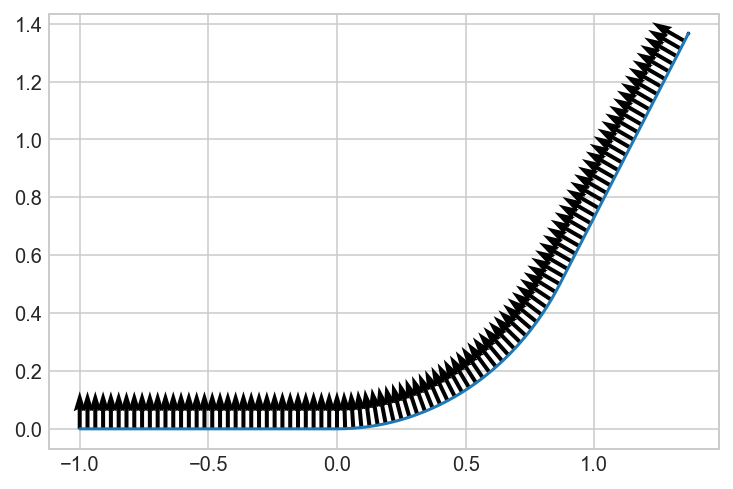

In [382]:
plt.plot(c_l[:,0],c_l[:,1],'-')
plt.quiver(c_l[:,0],c_l[:,1],c_n[:,0],c_n[:,1])

In [204]:
print(f"p_0=\n{s.p0}\n")
print(f"p_1=\n{s.p1}\n")
print(f"r_0=\n{s.r0}\n")
print(f"r_1=\n{s.r1}\n")

print(f"n_plane=\n{s.n_plane}\n")
print(f"n0=\n{s.n0}\n")
print(f"n1=\n{s.n1}\n")
print(f"arc_radius=\n{s.arc_radius}\n")
print(f"pc=\n{s.pc}\n")
print(f"arc_angle = ->(deg)\n{np.rad2deg(s.arc_angle)}\n")

p_0=
[[-1.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.8660254  0.5        0.       ]]

p_1=
[[0.        0.        0.       ]
 [0.8660254 0.5       0.       ]
 [1.3660254 1.3660254 0.       ]]

r_0=
[1.  1.  0.8]

r_1=
[1.  0.8 0.5]

n_plane=
[[0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]

n0=
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]

n1=
[[ 0.         0.         0.       ]
 [-0.8660254  0.5        0.       ]
 [ 0.         0.         0.       ]]

arc_radius=
[inf  1. inf]

pc=
[[inf inf inf]
 [ 0.  1.  0.]
 [inf inf inf]]

arc_angle = ->(deg)
[ 0. 60.  0.]



In [24]:
a = np.array([[1,0,0],[2,3,1],[0,2,1],[0,2,1]])
b = np.array([[0,1,0],[2,3,1],[0,2,2],[0,2,1]])

In [27]:
n = np.cross(a,b)
np.linalg.norm(n,ord=2,axis=-1)

array([1., 0., 2., 0.])

In [30]:
np.cross([1,0,0],[0,0,0])

array([0, 0, 0])

In [90]:
numba.bool

AttributeError: module 'numba' has no attribute 'bool'

In [345]:
dt = 0.001
v0 = np.array([0,0,1])
v0 = v0/np.linalg.norm(v0)*np.pi/4
v1 = np.array([0,1,0])
# v1 = v1/np.linalg.norm(v1) * dt
v1 = v1 * dt

r0 = Rotation.from_rotvec(v0).as_matrix()
r1 = np.matmul(Rotation.from_rotvec(v1).as_matrix(),r0)

A = r1.dot(r0.T)
theta = np.arccos((A.trace()-1)/2)
w = 1/(2*dt)*theta/np.sin(theta)*(A-A.T)
w_a = np.array((w[2,1],w[0,2],w[1,0]))
w_a

array([0., 1., 0.])

In [348]:
with np.printoptions(precision=3,suppress=True):
    print(r0)
    print(r1)
    print(w_a)
    print(r1.T.dot(w_a[:,np.newaxis]))

[[ 0.707 -0.707  0.   ]
 [ 0.707  0.707  0.   ]
 [ 0.     0.     1.   ]]
[[ 0.707 -0.707  0.001]
 [ 0.707  0.707  0.   ]
 [-0.001  0.001  1.   ]]
[0. 1. 0.]
[[0.707]
 [0.707]
 [0.   ]]


In [308]:
r0.T.dot(w_a.T).dot(r0)

array([0.58834841, 0.78446454, 0.19611614])

In [214]:
r1 - (w*dt+r0)

array([[-6.74868378e-04,  3.69007478e-04,  1.07053761e-07],
       [-3.68840134e-04, -6.74930699e-04,  2.14330240e-07],
       [ 4.70849549e-04,  3.26951307e-04, -1.78571414e-07]])

In [215]:
from scipy.linalg import expm

In [216]:
r1 - r0.dot(expm(w*dt))

array([[ 1.20210131e-07,  9.01575979e-08,  2.10557379e-05],
       [ 9.01575982e-08, -1.20210131e-07, -5.72636093e-04],
       [ 4.70742317e-04,  3.26737066e-04,  1.11022302e-16]])

In [217]:
r0.dot(expm(w*dt))-(w*dt+r0)

array([[-6.74988589e-04,  3.68917320e-04, -2.09486841e-05],
       [-3.68930292e-04, -6.74810489e-04,  5.72850423e-04],
       [ 1.07231935e-07,  2.14241153e-07, -1.78571414e-07]])

In [233]:
def matmul(a, b):
    a00 = a[0, 0]
    a01 = a[0, 1]
    a02 = a[0, 2]
    a10 = a[1, 0]
    a11 = a[1, 1]
    a12 = a[1, 2]
    a20 = a[2, 0]
    a21 = a[2, 1]
    a22 = a[2, 2]

    b00 = b[0, 0]
    b01 = b[0, 1]
    b02 = b[0, 2]
    b10 = b[1, 0]
    b11 = b[1, 1]
    b12 = b[1, 2]
    b20 = b[2, 0]
    b21 = b[2, 1]
    b22 = b[2, 2]

    o00 = a00*b00+a01*b10+a02*b20
    o01 = a00*b01+a01*b11+a02*b21
    o02 = a00*b02+a01*b12+a02*b22
    o10 = a10*b00+a11*b10+a12*b20
    o11 = a10*b01+a11*b11+a12*b21
    o12 = a10*b02+a11*b12+a12*b22
    o20 = a20*b00+a21*b10+a22*b20
    o21 = a20*b01+a21*b11+a22*b21
    o22 = a20*b02+a21*b12+a22*b22

    return np.array([[o00, o01, o02],
                     [o10, o11, o12],
                     [o20, o21, o22]])

def transpose(a):
    a00 = a[0, 0]
    a01 = a[0, 1]
    a02 = a[0, 2]
    a10 = a[1, 0]
    a11 = a[1, 1]
    a12 = a[1, 2]
    a20 = a[2, 0]
    a21 = a[2, 1]
    a22 = a[2, 2]
    return np.array([[a00, a10, a20],
                     [a01, a11, a21],
                     [a02, a12, a22]])

In [234]:
r0.T-transpose(r0)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [230]:
r0.dot(r1)-matmul(r0,r1)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [243]:
a = np.arange(1,10).reshape((3,-1))
b = np.array(a)
(a.dot(b)).ravel()


array([ 30,  36,  42,  66,  81,  96, 102, 126, 150])

In [263]:
(a.dot(a.T)).ravel()

array([ 14,  32,  50,  32,  77, 122,  50, 122, 194])

In [277]:
np.linalg.inv(a)

array([[-4.50359963e+15,  9.00719925e+15, -4.50359963e+15],
       [ 9.00719925e+15, -1.80143985e+16,  9.00719925e+15],
       [-4.50359963e+15,  9.00719925e+15, -4.50359963e+15]])

In [284]:
e = np.array([1,2,3,7,6,8,2,7,3]).reshape((3,3))
(np.linalg.inv(e)*np.linalg.det(e))

array([[-38.,  15.,  -2.],
       [ -5.,  -3.,  13.],
       [ 37.,  -3.,  -8.]])

In [285]:
np.linalg.det(e*63)

15752960.999999993

In [286]:
a.dot(a[0])

array([14, 32, 50])

In [358]:
t = 1e-100
t/np.sin(t)

1.0

In [ ]:
import pyarrow as pa
import pandas as pd
import numpy as np
import sys

data = [
    [[1,3,4],[1,3,4],[1,3,4],[1,3,4]],
    ['foo', 'bar', 'baz', None],
    [True, None, False, True]
]
batch = pa.record_batch(data, names=['f0', 'f1', 'f2'])

sink = pa.OSFile("..//data//test.arrow","wb")

writer = pa.ipc.new_file(sink, batch.schema)
for i in range(1000):
    writer.write_batch(batch)
writer.close()

In [ ]:
with pa.OSFile("..//data//test.arrow") as sink:
# with pa.memory_map("..//data//test.arrow") as sink:
    reader = pa.ipc.open_file(sink)
    df = reader.read_pandas(use_threads=True)
#     sink.close()
print(sys.getsizeof(df))
df